### Visualize waypoint distribution

In [1]:

import sys
sys.path.insert(0, '..')

from hydra import core, initialize, compose
from omegaconf import OmegaConf

# CHANGE ME
DATASET_DIR = '/mnt/4TB1/dataset/nuscenes'
LABELS_DIR = '/mnt/4TB1/dataset/cvt_labels_nuscenes_v5'


core.global_hydra.GlobalHydra.instance().clear()        # required for Hydra in notebooks

initialize(config_path='../config')

# Add additional command line overrides
cfg = compose(
    config_name='config',
    overrides=[
        'experiment.save_dir=../logs/',                 # required for Hydra in notebooks
        '+experiment=cvt_nuscenes_waypoint_mm_mlp',
        f'data.dataset_dir={DATASET_DIR}',
        f'data.labels_dir={LABELS_DIR}',
        'data.version=v1.0-trainval',
        'loader.batch_size=1',
    ]
)

# resolve config references
OmegaConf.resolve(cfg)

print(list(cfg.keys()))

['experiment', 'loader', 'optimizer', 'scheduler', 'trainer', 'model', 'data', 'visualization', 'loss', 'metrics']


### Visualize Train dataset

In [2]:
import torch
import numpy as np

import logging
from pathlib import Path

from cross_view_transformer.common import setup_experiment, load_backbone, load_backbone_road, load_backbone_vehicle, load_backbone_lane

SPLIT = 'train'
log = logging.getLogger(__name__)

model_module, data_module, viz_fn = setup_experiment(cfg)

dataset = data_module.get_split(SPLIT, loader=False)
dataset = torch.utils.data.ConcatDataset(dataset)
# dataset = torch.utils.data.Subset(dataset, range(0, len(dataset), SUBSAMPLE))
dataset = torch.utils.data.Subset(dataset, range(0, len(dataset)))


loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=32)
print(len(dataset))

Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b4
17630


In [3]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create an empty grid of 100m by 100m, divided by 4m cells
grid_size = 12*2 + 1  # 25 x 25 grid
grid = np.zeros((grid_size, grid_size))

for data in tqdm(loader):
    endpoint = data["label_waypoint"].to(device)[:, -1, :]
    # import pdb; pdb.set_trace()
    for row in endpoint:
        x, y = row
        if x.item() >= 0:
            x = x.item() + 4
            grid_x = 12 + int(x // 8)
        else:
            x = x.item() - 4
            grid_x = 12 + int(x // 8)
        if y.item() >= 0:
            y = y.item() + 4
            grid_y = 12 - int(y // 8)
        else:
            y = y.item() - 4
            grid_y = 12 - int(y // 8)
        if 0 <= grid_x < grid_size and 0 <= grid_y < grid_size:
            grid[grid_y][grid_x] += 1


100%|████████████████████████████████████████████████████████████████████████████████| 551/551 [11:05<00:00,  1.21s/it]


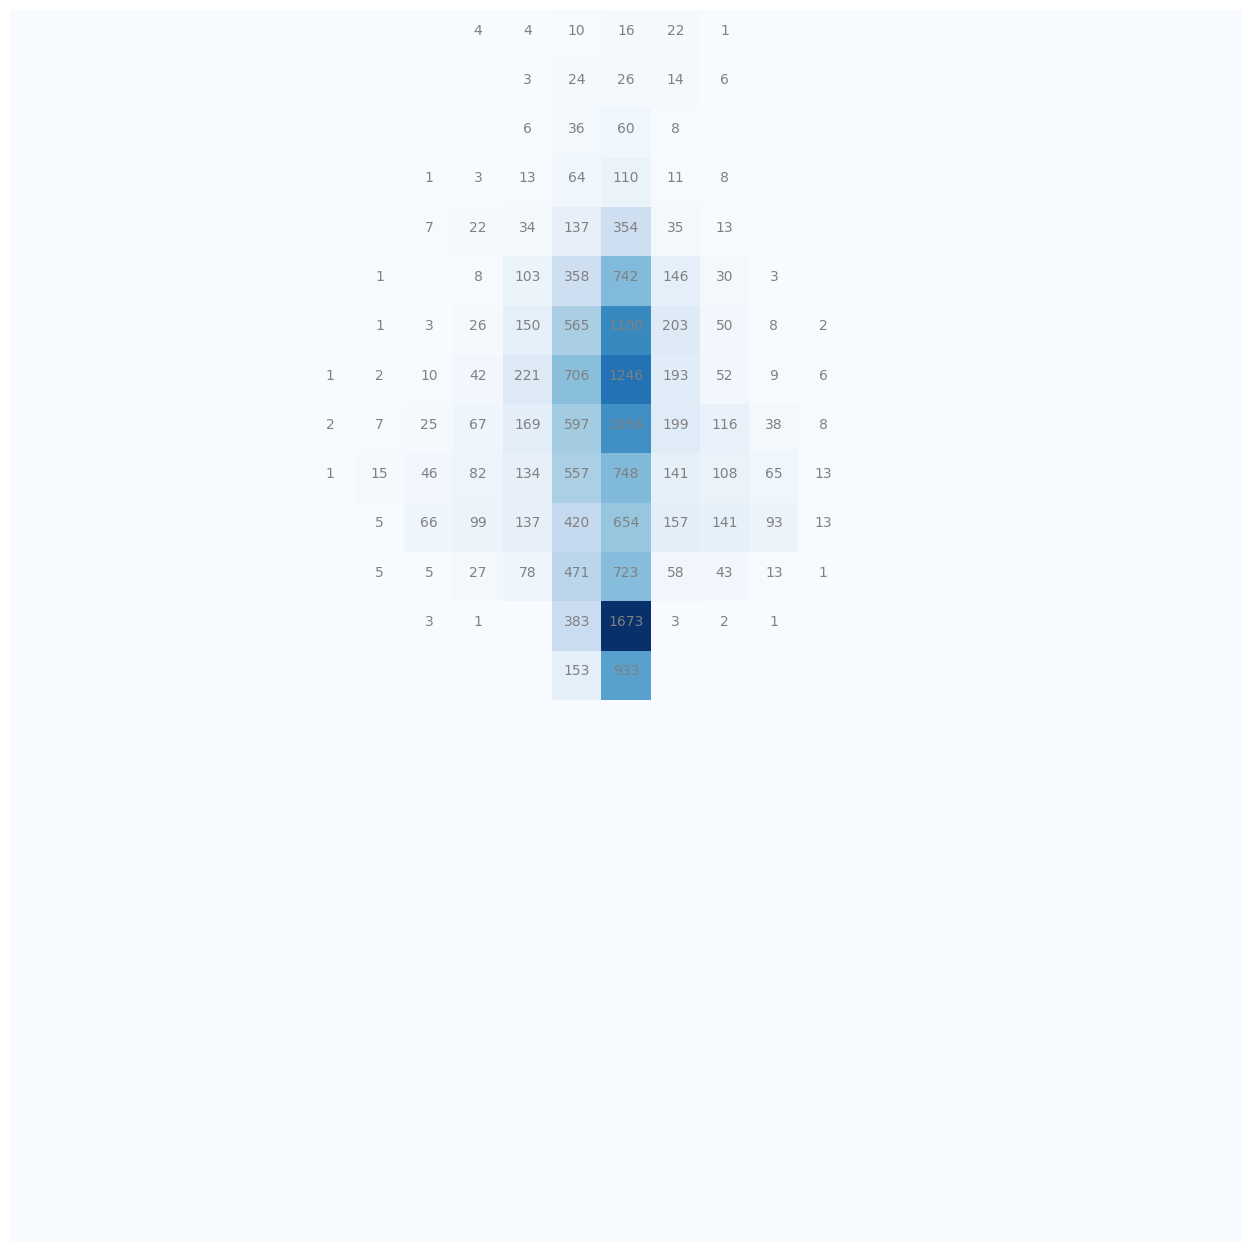

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(grid, cmap='Blues')
for i in range(grid_size):
    for j in range(grid_size):
        if grid[i,j] != 0:
            plt.text(j, i, int(grid[i, j].item()), ha="center", color='gray')
        
plt.axis('off');

portion visualization

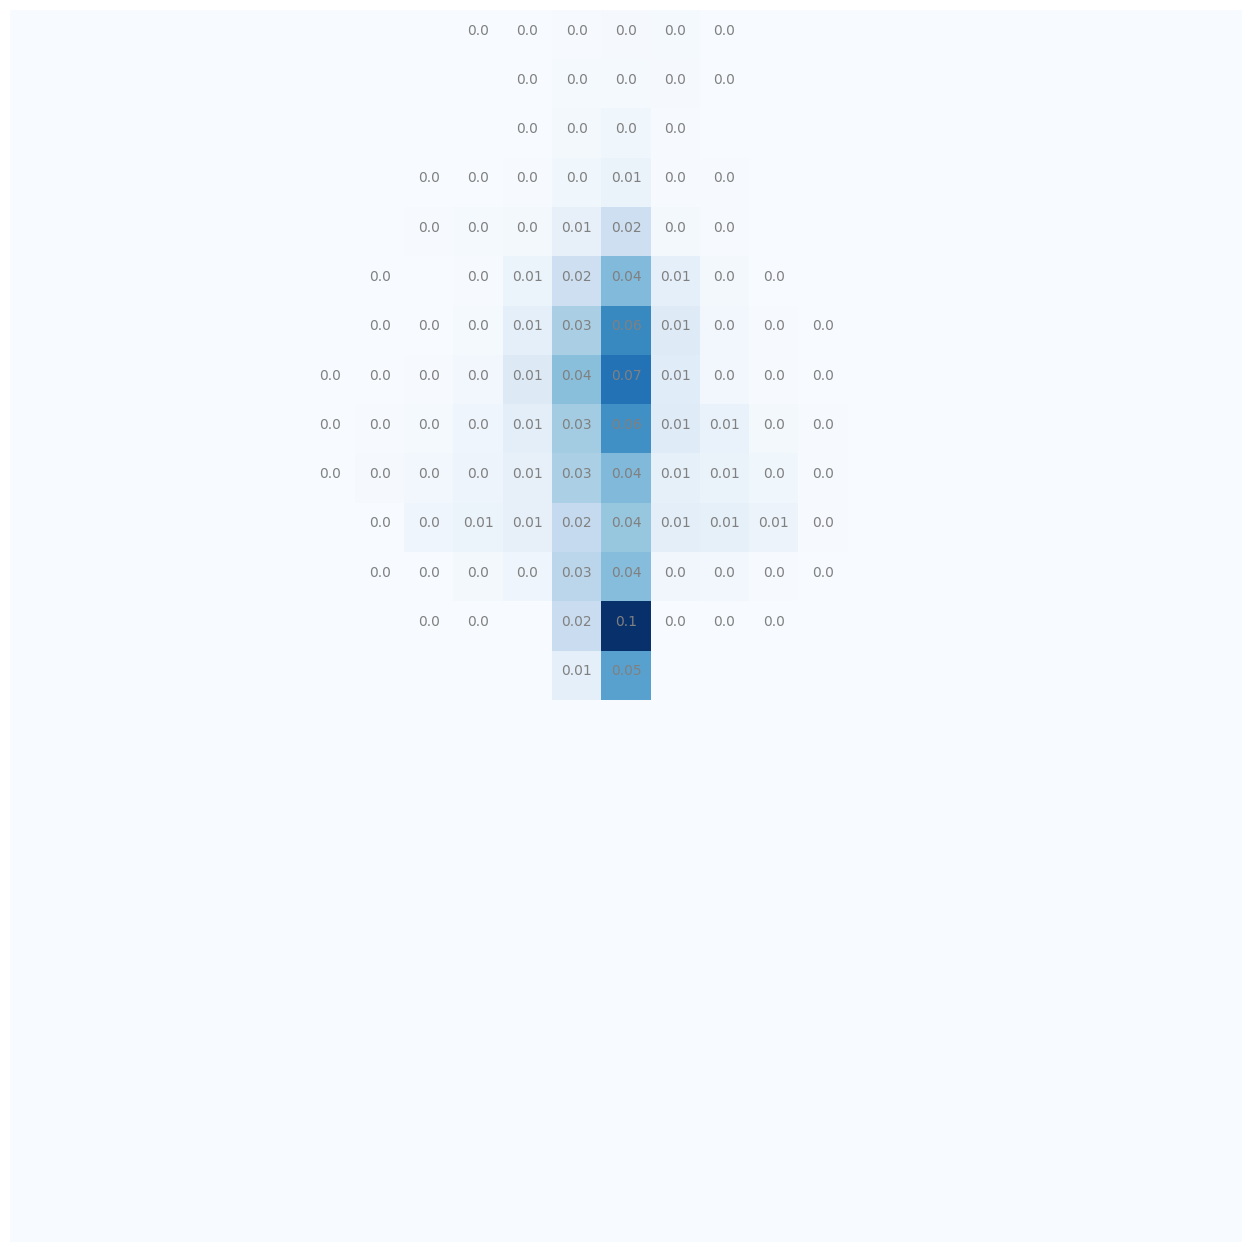

In [5]:
total = grid.sum()
print(total)

plt.figure(figsize=(16,16))
plt.imshow(grid, cmap='Blues')
for i in range(grid_size):
    for j in range(grid_size):
        if grid[i,j] != 0:
            plt.text(j, i, round(int(grid[i, j].item()) / total, 2), ha="center", color='gray')
        
plt.axis('off');

In [6]:
center = grid[12, 12]
center

1673.0

### Visualize Validation dataset

In [8]:
import torch
import numpy as np

import logging
from pathlib import Path

from cross_view_transformer.common import setup_experiment, load_backbone, load_backbone_road, load_backbone_vehicle, load_backbone_lane

SPLIT = 'val'
log = logging.getLogger(__name__)

model_module, data_module, viz_fn = setup_experiment(cfg)

dataset = data_module.get_split(SPLIT, loader=False)
dataset = torch.utils.data.ConcatDataset(dataset)
# dataset = torch.utils.data.Subset(dataset, range(0, len(dataset), SUBSAMPLE))
dataset = torch.utils.data.Subset(dataset, range(0, len(dataset)))


loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4)
print(len(dataset))

Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b4
3769


In [9]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create an empty grid of 100m by 100m, divided by 4m cells
grid_size = 12*2 + 1  # 25x25 grid
grid = np.zeros((grid_size, grid_size))

for data in tqdm(loader):
    endpoint = data["label_waypoint"].to(device)[:, -1, :]
    # import pdb; pdb.set_trace()
    for row in endpoint:
        x, y = row
        if x.item() >= 0:
            x = x.item() + 4
            grid_x = 12 + int(x // 8)
        else:
            x = x.item() - 4
            grid_x = 12 + int(x // 8)
        if y.item() >= 0:
            y = y.item() + 4
            grid_y = 12 - int(y // 8)
        else:
            y = y.item() - 4
            grid_y = 12 - int(y // 8)
        if 0 <= grid_x < grid_size and 0 <= grid_y < grid_size:
            grid[grid_y][grid_x] += 1
    # val_endpoints = torch.concat([val_endpoints, endpoint], dim=0)

100%|████████████████████████████████████████████████████████████████████████████████| 943/943 [08:08<00:00,  1.93it/s]


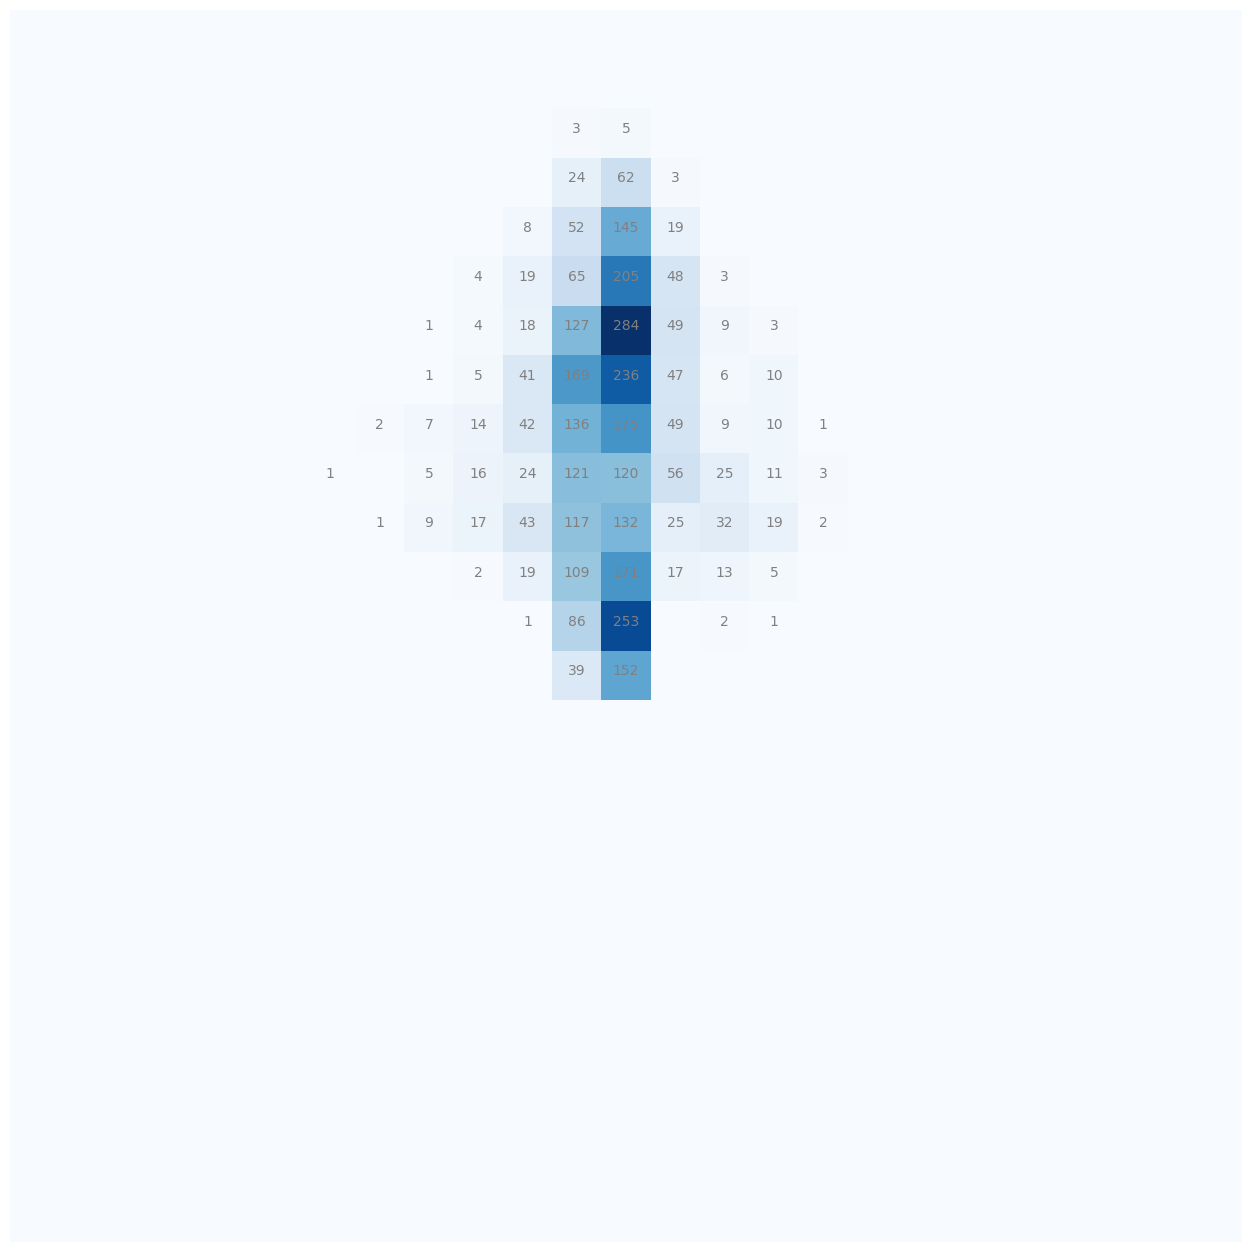

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(grid, cmap='Blues')
for i in range(grid_size):
    for j in range(grid_size):
        if grid[i,j] != 0:
            plt.text(j, i, int(grid[i, j].item()), ha="center", color='gray')
        
plt.axis('off');

portion visualization

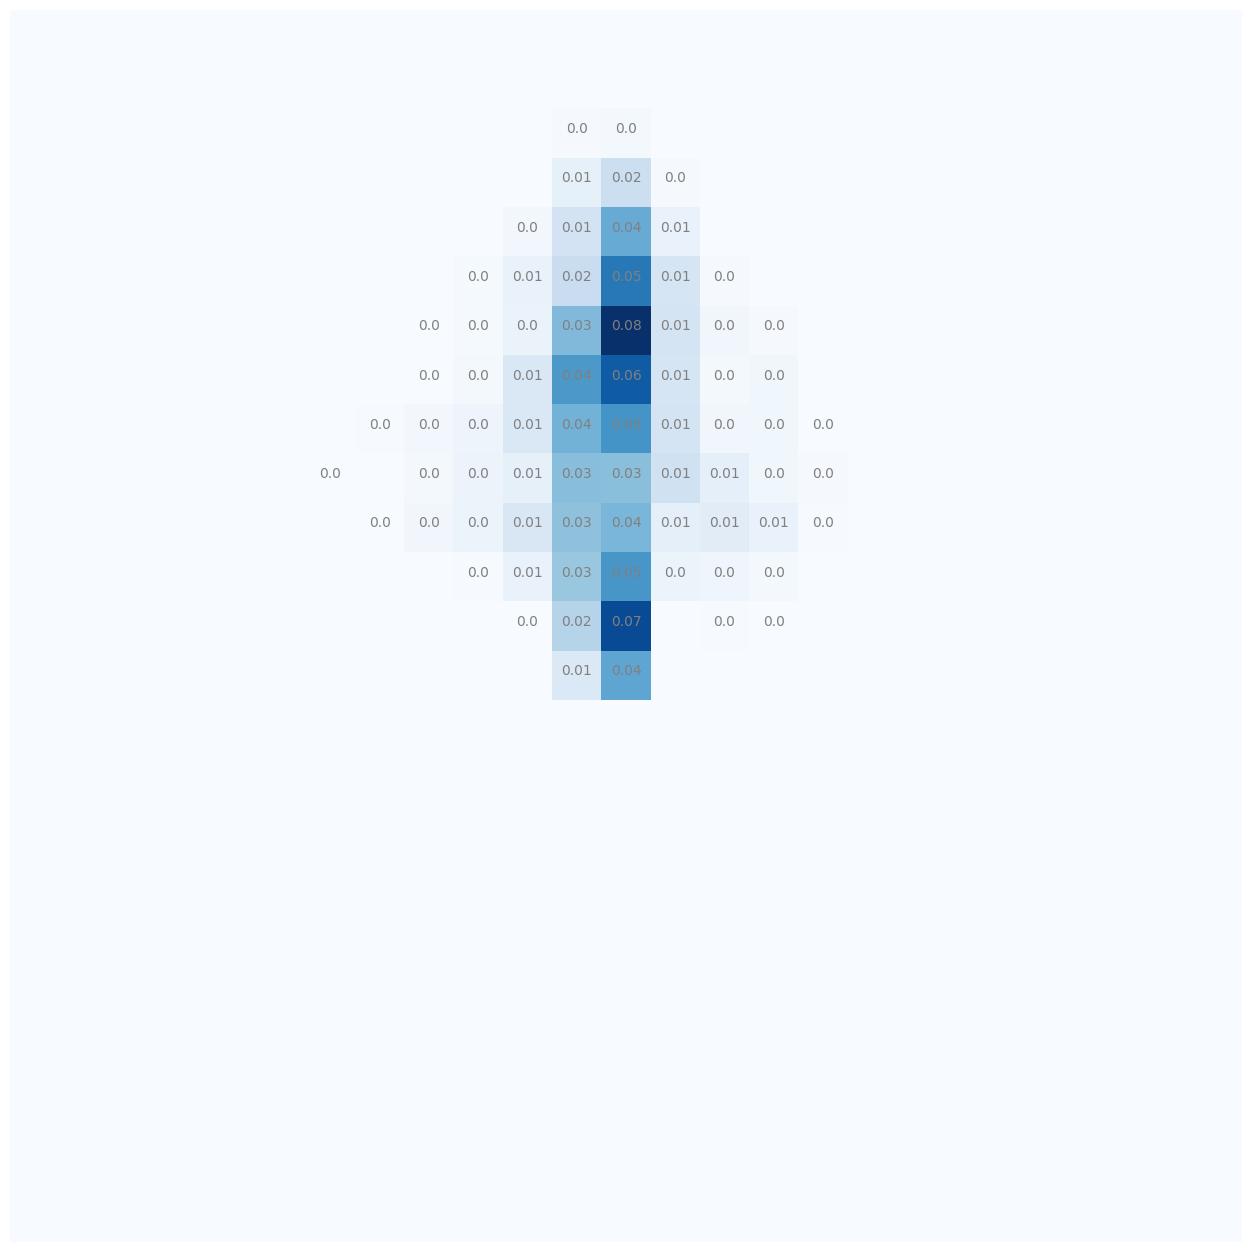

In [11]:
total = grid.sum()
print(total)

plt.figure(figsize=(16,16))
plt.imshow(grid, cmap='Blues')
for i in range(grid_size):
    for j in range(grid_size):
        if grid[i,j] != 0:
            plt.text(j, i, round(int(grid[i, j].item()) / total, 2), ha="center", color='gray')
        
plt.axis('off');

In [ ]:
center = grid[12, 12]
center